In [71]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy

Підготовка данних

In [72]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

In [82]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_loss) / 784.)
        return reconstructed

#  енкодер
inputs = Input(shape=(original_dim,))
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# декодер
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
x_decoded = decoder.predict(z_sample)

vae = VAE(encoder, decoder)
vae.compile(optimizer='rmsprop', loss=binary_crossentropy)

1/1 [==============================] - 0s 51ms/step


Тренування моделі

In [85]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=50,
        batch_size=255,
        validation_data=(x_test, x_test))

Epoch 1/50
236/236 [==============================] - 9s 37ms/step - loss: 0.2509 - val_loss: 0.2480
Epoch 2/50
236/236 [==============================] - 9s 39ms/step - loss: 0.2466 - val_loss: 0.2438
Epoch 3/50
236/236 [==============================] - 9s 38ms/step - loss: 0.2410 - val_loss: 0.2358
Epoch 4/50
236/236 [==============================] - 8s 33ms/step - loss: 0.2323 - val_loss: 0.2292
Epoch 5/50
236/236 [==============================] - 9s 38ms/step - loss: 0.2260 - val_loss: 0.2232
Epoch 6/50
236/236 [==============================] - 9s 38ms/step - loss: 0.2222 - val_loss: 0.2207
Epoch 7/50
236/236 [==============================] - 8s 35ms/step - loss: 0.2199 - val_loss: 0.2188
Epoch 8/50
236/236 [==============================] - 9s 38ms/step - loss: 0.2182 - val_loss: 0.2174
Epoch 9/50
236/236 [==============================] - 9s 39ms/step - loss: 0.2168 - val_loss: 0.2162
Epoch 10/50
236/236 [==============================] - 9s 36ms/step - loss: 0.2158 - val_lo

Візуалізація результатів

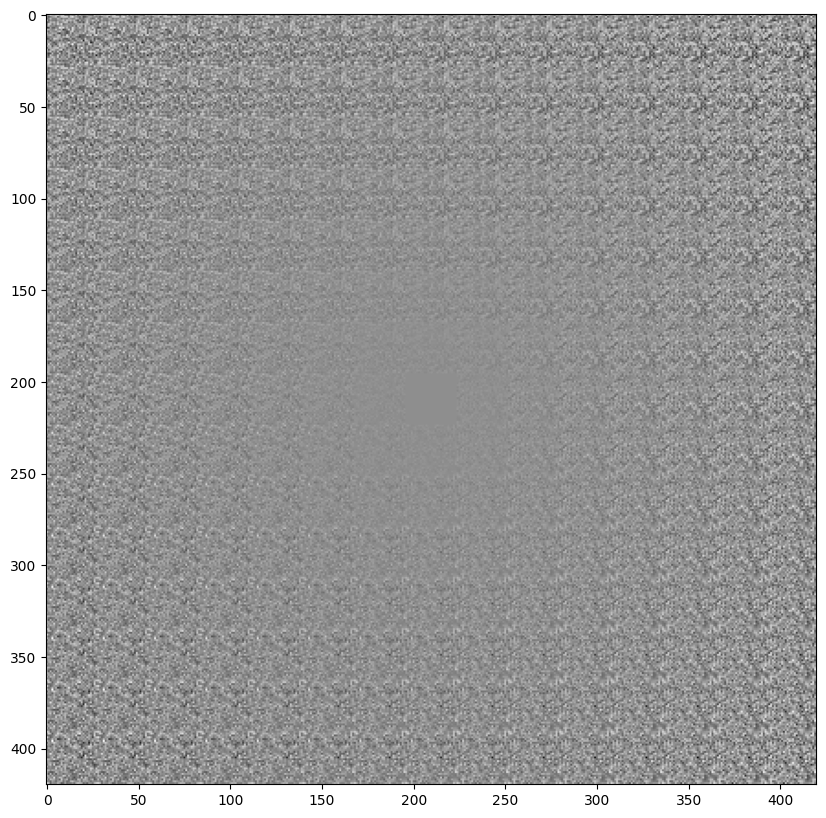

In [86]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_mean(decoder_h(z_sample))
        digit = x_decoded[0].numpy().reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Порівняння зі звичайним автокодувальником

Звичайний автокодувальник працює, намагаючись мінімізувати втрату між вхідними даними та їх реконструкцією, без будь-якого припущення про розподіл даних у прихованому просторі. Варіаційний автокодувальник, з іншого боку, оптимізує границю логарифмічної правдоподібності даних. Це дозволяє генерувати нові дані, семплюючи з прихованого простору.